# Overhead sDIC Decomposition

Run the DIC decomposition but for every grid cell in the given EBUS.

In [31]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import esmtools as et
import glob
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy.polynomial.polynomial as poly
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm

## Functions

In [32]:
def load_variables(ebu):
    v_list = ['FG_CO2', 'Jint_100m_circ', 'Jint_100m_DIC', 'sDIC_int100m_tendency']
    basepath = '/glade/work/rbrady/EBUS_BGC_Variability/sDIC_decomposition/'
    ds = xr.Dataset()
    for name in v_list:
        filepath = (basepath + name + '/' + ebu + '/' + ebu.lower() +
                   '-' + name + '-residuals-chavez-800km.nc')
        temp_ds = xr.open_dataarray(filepath)
        if name == 'FG_CO2' or name == 'Jint_100m_DIC':
            temp_ds = temp_ds.isel(ensemble=slice(1,34))
        ds = xr.merge([ds, temp_ds])
    return ds

In [33]:
def load_index(idx):
    if idx == 'NPGO':
        ds = xr.open_mfdataset('/glade/work/rbrady/EBUS_BGC_Variability/NPGO/*.nc', 
                              concat_dim='ensemble')
        ds = ds.isel(ensemble=slice(1,34))
        ds = ds['pc'].to_dataset()
        ds = ds.rename({'pc': 'NPGO'})
    else:
        ds = xr.open_dataset('/glade/work/rbrady/cesmLE_CVDP/processed/cvdp_detrended_BGC.nc')
        ds = ds[idx]
        ds = ds.isel(ensemble=slice(1,34))
    return ds

In [34]:
def vectorized_regression(x, y, suppress_output=False):
    """
    Vectorized function for regressing many time series onto a fixed time
    series.
    
    Input
    -----
    x : array_like
      Time series of independent values (time, climate index, etc.)
    y : array_like
      Grid of values to act as dependent values (SST, CO2 flux, etc.)
      
    Return
    ------
    m : array_like
      Grid of slopes from linear regression
    """
    if not suppress_output:
        print("Make sure that time is the first dimension in your inputs.")
    if np.isnan(x).any():
        raise ValueError("Please supply an independent axis (x) without NaNs.")
        
    # convert to numpy array if xarray
    if isinstance(y, xr.DataArray):
        XARRAY = True
        dim1 = y.dims[1]
        dim2 = y.dims[2]
        y = np.asarray(y)
        
    data_shape = y.shape
    y = y.reshape((data_shape[0], -1))
    # NaNs screw up vectorized regression; just fill with zeros.
    y[np.isnan(y)] = 0
    coefs = poly.polyfit(x, y, deg=1)
    m = coefs[1].reshape( (data_shape[1], data_shape[2]) )
    m[m == 0] = np.nan
    
    if XARRAY:
        m = xr.DataArray(m, dims=[dim1, dim2])
    return m

In [35]:
def regression(ds):
    m1, m2, m3, m4 = ([] for i in range(4))
    for label, group in ds.groupby('ensemble'):
        """
        The manually integrate
        """
        M1, _, _, _, _ = et.stats.linear_regression(group['index'], group['FG_CO2_AW'])
        M2, _, _, _, _ = et.stats.linear_regression(group['index'], group['Jint_100m_circ'])
        M3, _, _, _, _ = et.stats.linear_regression(group['index'], group['Jint_100m_DIC_AW'])
        M4, _, _, _, _ = et.stats.linear_regression(group['index'], group['sDIC_int100m_tendency_AW'])
    #    R, P, N = et.stats.pearsonr(group['NPGO'], group['FG_CO2_AW'])
        m1.append(M1)
        m2.append(M2)
        m3.append(M3)
        m4.append(M4)
    results = xr.Dataset({'CO2': ('ensemble', m1),
                      'Circulation': ('ensemble', m2),
                      'Biology': ('ensemble', m3),
                      'Tendency': ('ensemble', m4)}) 
    return results

In [37]:
EBU = 'HumCS'
IDX = 'nino3'
ds = load_variables(EBU)

# Load in index
if IDX == 'NPGO':
    index = load_index('NPGO')
    ds = xr.merge([ds, npgo.load()])
    ds = ds.rename({'NPGO': 'index'})
else:
    index = load_index(IDX)
    ds = xr.merge([ds, index])
    ds = ds.rename({IDX: 'index'})

In [38]:
m1, m2, m3, m4 = ([] for i in range(4))
for label, group in ds.groupby('ensemble'):
    M1 = vectorized_regression(group.index, group.FG_CO2, suppress_output=True)
    M2 = vectorized_regression(group.index, group.Jint_100m_circ,
                               suppress_output=True)
    M3 = vectorized_regression(group.index, group.Jint_100m_DIC,
                               suppress_output=True)
    M4 = vectorized_regression(group.index, group.sDIC_int100m_tendency,
                               suppress_output=True)
    m1.append(M1.values)
    m2.append(M2.values)
    m3.append(M3.values)
    m4.append(M4.values)
results = xr.Dataset({'CO2': (('ensemble', 'nlat', 'nlon'), m1),
                      'Circulation': (('ensemble', 'nlat', 'nlon'), m2),
                      'Biology': (('ensemble', 'nlat', 'nlon'), m3),
                      'Tendency': (('ensemble', 'nlat', 'nlon'), m4)}) 

## Visualize

In [48]:
def plot_term(ax, EBU, term, title, cmap="RdBu_r"):
    lon = term.TLONG
    lat = term.TLAT
    x0,x1,y0,y1 = et.ebus.visual_bounds(EBU)
    p = ax.pcolor(lon-1, lat, term.mean('ensemble'), transform=ccrs.PlateCarree(),
                cmap=cmap, vmin=-1.5, vmax=1.5, edgecolor='w')
    ax.set_extent([x0,x1,y0,y1])
    ax.add_feature(cfeature.LAND, facecolor='k')
    ax.outline_patch.set_edgecolor('white')
    ax.set_title(title)
    return p

In [49]:
results.coords['TLAT'] = ds['TLAT']
results.coords['TLONG'] = ds['TLONG']

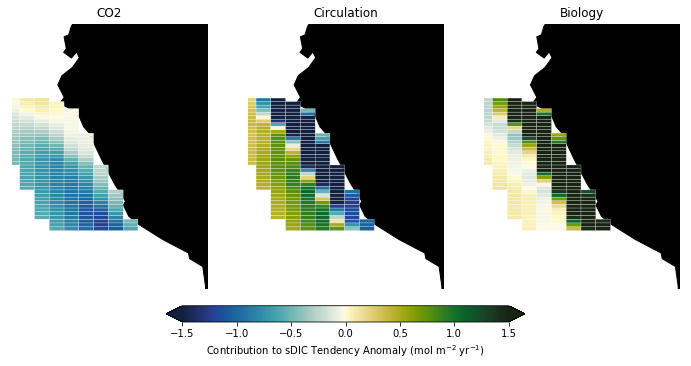

In [52]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6), 
                     subplot_kw=dict(projection=ccrs.Mercator()))

# Plot Terms 
terms = [results['CO2'], results['Circulation'], results['Biology']]
titles = ['CO2', 'Circulation', 'Biology']
for i, name in enumerate(terms):
    p = plot_term(ax[i], EBU, name, titles[i], cmap=cm.delta)

cb = f.colorbar(p, ax=ax.ravel().tolist(), orientation='horizontal',
                fraction=0.05, pad=0.05, ticks=[-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5],
                extend="both")
cb.set_label('Contribution to sDIC Tendency Anomaly (mol m$^{-2}$ yr$^{-1})$')


#et.vis.savefig(EBU + '_sDIC_spatial_decomposition_' + IDX, extension='.eps', dpi=300)